In [1]:
#pip install nilearn nibabel seaborn networkx nxviz community sklearn matplotlib plotly dash


In [2]:
# Libraries
from nilearn import datasets
import pandas as pd
from nilearn import plotting
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import resample_to_img
from sklearn.metrics import jaccard_score
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import numpy as np
import glob
#import seaborn as sns
# Network Libraries
import networkx as nx
#from nxviz import CircosPlot
import community
import plotly 
#import dash
import os
from PIL import Image
import tqdm


In [3]:
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas.labels=atlas.labels.tolist()
atlas_labels = [label.decode('utf-8') for label in atlas.labels]
atlas_filename=atlas.maps

In [4]:
# def load_data(subject,iter,ses):

#         # Locate the data of the first subject
#         func = f'/home/mina94/scratch/fixSeed_threads/fmriprep_mca-output/iter_{iter}/{subject}/ses-{ses}/func/{subject}_ses-{ses}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
#         #template used 
#         template='/home/mina94/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz'
#         # atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
#         #atlas='/home/mina94/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_atlas-Schaefer2018_desc-100Parcels17Networks_dseg.nii.gz'
#        #maybe add this atlas feature in public env t obe accessible
#         # atlas.labels=atlas.labels.tolist()
#         # atlas_labels = [label.decode('utf-8') for label in atlas.labels]
#         return func, template

In [5]:
def compute_timeseries(sub,iter, ses): #(func,sub,iter, ses)
    func = f'/home/mina94/scratch/fixSeed_threads/fmriprep_mca-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    # func = f'/home/mina94/scratch/fixSeed_threads/fmriprep_ieee-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    fmri_img=nib.load(func)
    confounds_fn = f'/home/mina94/scratch/fixSeed_threads/fmriprep_mca-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_desc-confounds_timeseries.tsv'
    # confounds_fn = f'/home/mina94/scratch/fixSeed_threads/fmriprep_ieee-output/iter_{iter}/{sub}/ses-{ses}/func/{sub}_ses-{ses}_task-rest_desc-confounds_timeseries.tsv'
    # We need to load the confounds and fill nas
    confounds = pd.read_table(confounds_fn).fillna(method='bfill')
    confounds_to_include = ['global_signal', 'csf',
                                'white_matter', 'trans_x', 'trans_y',
                                'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x_power2',
                                'trans_y_power2', 'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2']
    confounds = confounds[confounds_to_include]
    # Initialize the NiftiLabelsMasker with some standard options for preprocessing
    masker = NiftiLabelsMasker(atlas_filename, standardize=True, smoothing_fwhm=6,memory='nilearn_cache', verbose=5)
    time_series = masker.fit_transform(fmri_img, confounds)
    #plot the correlation matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # correlation_matrix[correlation_matrix<=0.005] = 0 applying threshold

    # Mask the main diagonal for visualization:
    np.fill_diagonal(correlation_matrix, 0)
    # Plot correlation matrix - note: matrix is ordered for block-like representation
    # title = f'iter_{iter}'
    # fig= plotting.plot_matrix(correlation_matrix, title=title, figure=(8,8), labels=atlas_labels,
    #                  vmax=0.8, vmin=-0.8, reorder=False);
    # Save the plot, create ses folder for each subject
    # fig.figure.savefig((f'{save_filepath}/views/{sub}/{ses}/{iter}_views.png'))
    # print(f'save the plot of {sub} for {iter} in {save_filepath}/views/{sub}/{ses}/{iter}_views.png')
    # plt.close(fig.figure)

    return time_series, correlation_matrix


In [6]:
def building_graph (correlation_matrix):
    G = nx.Graph()
    # Add nodes to the graph
    num_nodes = correlation_matrix.shape[0]
    G.add_nodes_from(range(num_nodes))
    print(f"Graph G with {num_nodes} nodes was built")
    # Add edges based on correlation matrix
    threshold = 0.05  # Adjust this threshold as needed
    #G.add_edges([(i, j, correlation_matrix[i, j] for i in ... for j in ...)])
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            #if j == i:
                #continue
            correlation = correlation_matrix[i, j]
            if abs(correlation) >= threshold:
                G.add_edge(i, j, weight=correlation)
    # Removing self-loops
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    return G

In [7]:
def compute_graph_measures(G):
    # Compute centrality
    degree_centralities = nx.degree_centrality(G)
    betweenness_centralities = nx.betweenness_centrality(G)
    eigenvector_centralities = nx.eigenvector_centrality(G)

    # Compute clustering coefficient
    clustering_coefficients = nx.clustering(G)

    # Compute shortest path lengths
    shortest_path_lengths = dict(nx.shortest_path_length(G))

    # Compute clustering coefficient
    avg_clustering_coefficient = nx.average_clustering(G)

    # Compute average shortest path length
    avg_shortest_path_length = nx.average_shortest_path_length(G)

    # Compute small-worldness
    small_worldness = avg_clustering_coefficient / avg_shortest_path_length
        # Construct the dictionary of graph metrics
    graph_metrics = {
        'degree_centralities': degree_centralities,
        'betweenness_centralities': betweenness_centralities,
        'eigenvector_centralities': eigenvector_centralities,
        'clustering_coefficients': clustering_coefficients,
        'shortest_path_lengths': shortest_path_lengths,
        'small_worldness': small_worldness
    }

    return graph_metrics
    
    # return {
    #     'degree_centralities': nx.degree_centrality(G),
    #     ...
    # }


In [8]:
# # base = 'fmriprep_mca-output'
# save_filepath='connectome_gifs'
# for sub in range (1,11): 
#         if sub < 10:
#             sub = f'sub-126BPCP02100{sub}'
#         else:
#             sub = 'sub-126BPCP021010'
#         for iter in tqdm.tqdm(range(1,11)):
#             try:
#                 func, template, confounds, atlas=load_data(sub,iter)
#                 # Plot MRI image without coordinate axes
#                 iter_dict[f'iter_{iter}'][f'{sub}']['time_series'], iter_dict[f'iter_{iter}'][f'{sub}']['correlation_matrix'] =   compute_timeseries(atlas , func,sub,iter,save_filepath)
#             except Exception as e:
#                 print(e)
#                 continue
#         frames = [Image.open(f'{save_filepath}/views/{sub}/{image}') for image in os.listdir(f'{save_filepath}/views/{sub}')]
#         frame_one = frames[0]

#         frame_one.save(f"{save_filepath}/{sub}.gif", format="GIF", append_images=frames,save_all=True, duration=200, loop=0)
#         print('Gif of one subject is made')


In [9]:
iter_dict={'iter_1':{}, 'iter_2': {}, 'iter_3': {},'iter_4': {},'iter_5': {},'iter_6': {},'iter_7': {},'iter_8': {},'iter_9': {},'iter_10': {}}
#iter_dict = { f'iter_{i}': {} for i in range(1, 11)}

In [10]:
#creating dictionary for each subject that include number of MCA runs dictonary of features, maybe for each session or run mak differen dictionary
"""
{'sub-126BPCP021007': {'iter_1': {},'iter_2': {},'iter_3': {},'iter_4': {}, 'iter_5': {}, 'iter_6': {}, 'iter_7': {}, 'iter_8': {},  'iter_9': {},  'iter_10': {}},
 'sub-126BPCP021009': {'iter_1': {}, 'iter_2': {}, 'iter_3': {}, 'iter_4': {}, 'iter_5': {}, 'iter_6': {}, 'iter_7': {}, 'iter_8': {}, 'iter_9': {}, 'iter_10': {}},
 'sub-126BPCP021003': {'iter_1': {}, 'iter_2': {}, 'iter_3': {}, 'iter_4': {}, ....
 }
"""
def create_subdict(base):
     sublist=[]
     for subj in glob.glob(f'{base}/iter_1/sub-*'):
          if subj.endswith('.html'):
            continue  # Skip elements that end with .HTML
          sub_id = os.path.basename(subj)
          sublist.append(sub_id)
     #Initialize the outer dictionary for each subject
     iter_names = ['iter_1', 'iter_2', 'iter_3', 'iter_4', 'iter_5', 'iter_6', 'iter_7', 'iter_8', 'iter_9', 'iter_10']

     # Initialize the main dictionary
     iter_dict = {subject: {iter_name: {} for iter_name in iter_names} for subject in sublist}      

     return iter_dict    


In [11]:
subdict_ses1=create_subdict('/home/mina94/scratch/fixSeed_threads/fmriprep_mca-output')

In [12]:

def compute_metrics_forall(subdict,ses):
    for sub, iter in subdict.items():
        for iters in iter.items():
            iters=iters[0]
            i=int(iters.split('_')[1])
            # func, template, confounds=load_data(sub,i, ses)
            subdict[sub][iters]['time_series'], subdict[sub][iters]['correlation_matrix'] =   compute_timeseries(sub, i, ses)
            subdict[sub][iters]['graph']= building_graph(subdict[sub][iters]['correlation_matrix'])
            subdict[sub][iters]['graph_metrics']= compute_graph_measures(subdict[sub][iters]['graph'])
                                                              
compute_metrics_forall(subdict_ses1,1)

/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]5.6s, 0.1min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.8s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.2s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.3s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.3s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


In [13]:
subdict_ses1['sub-126BPCP021010']['iter_6']['graph_metrics']['eigenvector_centralities']

{0: 0.08709950146611495,
 1: 0.10485792348814932,
 2: 0.09891505716354454,
 3: 0.10039093339817172,
 4: 0.0938424875767103,
 5: 0.09858371860005417,
 6: 0.10667759225698487,
 7: 0.1042836546123957,
 8: 0.10694170276344483,
 9: 0.10005788358841369,
 10: 0.09584898412543619,
 11: 0.0991349677862472,
 12: 0.09678522954857904,
 13: 0.0982354679047375,
 14: 0.09616395228287218,
 15: 0.10206715943711217,
 16: 0.09639138249479923,
 17: 0.10099869446083207,
 18: 0.09746519479280778,
 19: 0.09832545587488649,
 20: 0.10541052313434535,
 21: 0.09993169394816677,
 22: 0.10324438199143351,
 23: 0.10683128543745625,
 24: 0.10005695183041749,
 25: 0.09926516487795904,
 26: 0.10220689295677908,
 27: 0.09512452989557577,
 28: 0.09648926842377578,
 29: 0.09836894632557198,
 30: 0.09411385217391713,
 31: 0.0849439803616474,
 32: 0.1005105246770555,
 33: 0.09978724855074422,
 34: 0.09531677264834446,
 35: 0.1068435167256227,
 36: 0.09355041997923293,
 37: 0.10773704274237537,
 38: 0.09184291979716634,
 39

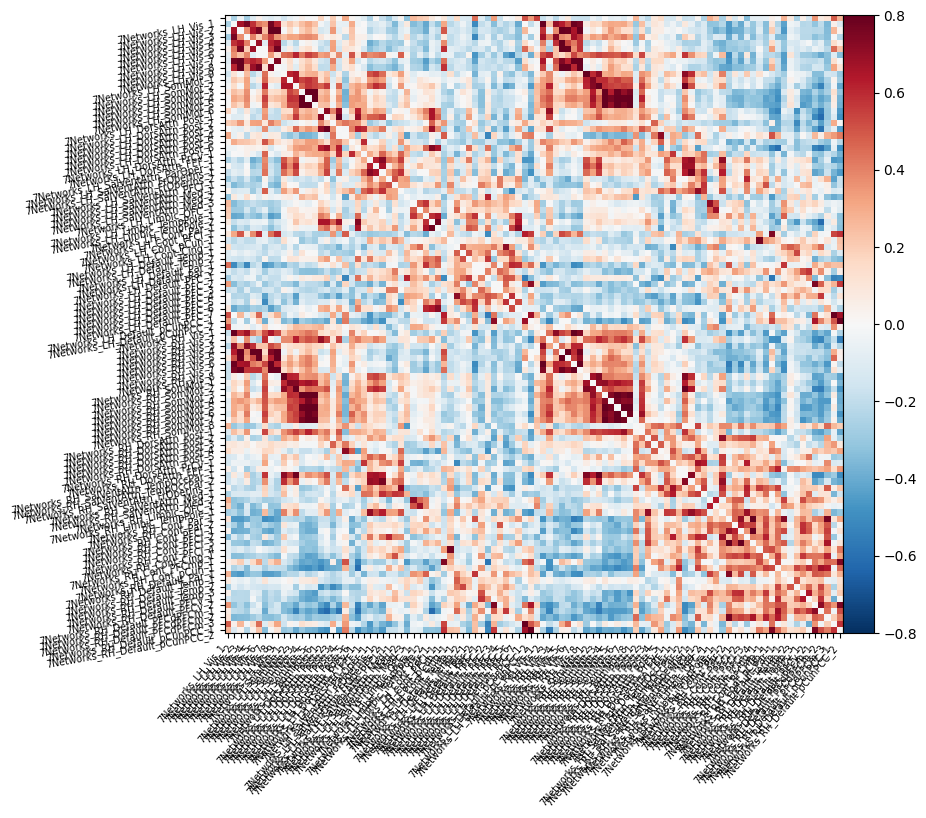

In [14]:
#figure the correlation matrix
correlation_matrix=subdict_ses1['sub-126BPCP021010']['iter_6']['correlation_matrix']
# correlation_matrix_copy =  correlation_matrix.copy()
# correlation_matrix_copy[correlation_matrix_copy<0.005]=0 
plotting.plot_matrix(correlation_matrix,figure=(8,8),labels=atlas_labels,
                     vmax=0.8, vmin=-0.8, reorder=False);


In [15]:
# func, template, confounds=load_data('sub-126BPCP021001',1,1)
# time_series1, correlation_matrix1=compute_timeseries( func,'sub-126BPCP021001',1, 1)
    # atlas,'/home/mina94/scratch/fixSeed_threads/fmriprep_mca-output/iter_1/sub-126BPCP021001/ses-1/func/sub-126BPCP021001_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' ,'sub-126BPCP021001',1, 1)

In [16]:
# for i in range (1,11):
#     iter_key = f'iter_{i}'
#     avg_degree=  sum(iter_dict[iter_key]['graph_metrics']['degree_centralities'].values()) / len(iter_dict[iter_key]['graph_metrics']['degree_centralities'].values())
#     avg_betweeness=sum(iter_dict[iter_key]['graph_metrics']['betweenness_centralities'].values()) / len(iter_dict[iter_key]['graph_metrics']['betweenness_centralities'].values())
#     avg_eigen =sum(iter_dict[iter_key]['graph_metrics']['eigenvector_centralities'].values()) / len(iter_dict[iter_key]['graph_metrics']['eigenvector_centralities'].values())
#     avg_clustering_coefficient = nx.average_clustering(iter_dict[iter_key]['graph'])
#     avg_shortest_path_length = nx.average_shortest_path_length(iter_dict[iter_key]['graph'])
#     small_worldness = avg_clustering_coefficient / avg_shortest_path_length
#     print(f'The mean value of metric for iteration {iter_key} : avg_degree: {avg_degree}, avg_betweeness: {avg_betweeness}, avg_eigen :{avg_eigen}, avg_clustering_coefficient:{avg_clustering_coefficient}, avg_shortest_path_length: {avg_shortest_path_length},small_worldness:{small_worldness}')

In [17]:
subdict_ses1['sub-126BPCP021001']['iter_1']['graph_metrics']


{'degree_centralities': {0: 0.8484848484848485,
  1: 0.8686868686868687,
  2: 0.8282828282828284,
  3: 0.797979797979798,
  4: 0.797979797979798,
  5: 0.8282828282828284,
  6: 0.8787878787878789,
  7: 0.9292929292929294,
  8: 0.8989898989898991,
  9: 0.8383838383838385,
  10: 0.888888888888889,
  11: 0.888888888888889,
  12: 0.7676767676767677,
  13: 0.9191919191919192,
  14: 0.9090909090909092,
  15: 0.9595959595959597,
  16: 0.9494949494949496,
  17: 0.8282828282828284,
  18: 0.9191919191919192,
  19: 0.8989898989898991,
  20: 0.9292929292929294,
  21: 0.9393939393939394,
  22: 0.9191919191919192,
  23: 0.9191919191919192,
  24: 0.8282828282828284,
  25: 0.9191919191919192,
  26: 0.9090909090909092,
  27: 0.8181818181818182,
  28: 0.9595959595959597,
  29: 0.8181818181818182,
  30: 0.9292929292929294,
  31: 0.8989898989898991,
  32: 0.8181818181818182,
  33: 0.7777777777777778,
  34: 0.7575757575757577,
  35: 0.7070707070707072,
  36: 0.9595959595959597,
  37: 0.9494949494949496,
  3

In [18]:
# # subdict_ses1['sub-126BPCP021001']['std_metric']['std_betweeness']
# for sub, iter in subdict_ses1.items():
#     for item, features in iter.items():
#         if "iter" in item:
#             print (item)

In [19]:

for sub, iter in subdict_ses1.items():
    subdict_ses1[sub]['std_metric'] = {
        'std_degree': [],
        'std_betweeness': [],
        'std_eigen': [],
        'std_clusteringCoefficient': []
                                          }
    for item , val in iter.items(): 
        if "iter" in item:
            std_degree=  np.std(list(subdict_ses1[sub][item]['graph_metrics']['degree_centralities'].values()))
            std_betweeness=np.std(list(subdict_ses1[sub][item]['graph_metrics']['betweenness_centralities'].values())) 
            std_eigen =np.std(list(subdict_ses1[sub][item]['graph_metrics']['eigenvector_centralities'].values())) 
            std_clusteringCoefficient = np.std(list(subdict_ses1[sub][item]['graph_metrics']['clustering_coefficients'].values()))
            # print(f'The std value of metric for subject {sub} and iteration {item} : std_degree: {std_degree}, std_betweeness: {std_betweeness}, std_eigen :{std_eigen}, std_clustering_coefficient:{std_clusteringCoefficient}')    
            subdict_ses1[sub]['std_metric']['std_degree'].append(std_degree)
            subdict_ses1[sub]['std_metric']['std_betweeness'].append(std_betweeness)
            subdict_ses1[sub]['std_metric']['std_eigen'].append(std_eigen)
            subdict_ses1[sub]['std_metric']['std_clusteringCoefficient'].append(std_clusteringCoefficient)

In [20]:
print(subdict_ses1['sub-126BPCP021001']['std_metric']['std_degree'])

[0.05974506258098519, 0.06037836013688266, 0.0588607275388559, 0.05828904261112528, 0.05956205164467427, 0.05954937401961457, 0.06002244249190134, 0.05715279695496568, 0.0590109966423375, 0.05846382274136478]


In [21]:
# df=pd.DataFrame.from_dict(subdict_ses1['sub-126BPCP021001']['std_metric'])
# long_df = pd.melt(df)
# long_df

In [22]:
# pip install seaborn

In [23]:
IEEE_metric = { f'sub-126BPCP021{i:03}': {} for i in range(1, 11)}

for i in range (1,11):
    sub= f'sub-126BPCP021{i:03}'
    print (sub)
    IEEE_metric[sub] = {}
    IEEE_metric[sub]['time_series'], IEEE_metric[sub]['correlation_matrix'] =   compute_timeseries(sub, 1,1)
    IEEE_metric[sub]['graph']= building_graph(IEEE_metric[sub]['correlation_matrix'])
    IEEE_metric[sub]['graph_metrics']= compute_graph_measures(IEEE_metric[sub]['graph'])

sub-126BPCP021001


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021002


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021003


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]2.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021004


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021005


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021006


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021007


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021008


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021009


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built
sub-126BPCP021010


/tmp/ipykernel_1763060/354648241.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds = pd.read_table(confounds_fn).fillna(method='bfill')


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]1.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Graph G with 100 nodes was built


In [24]:
# for sub, iter in IEEE_metric.items():
#         IEEE_metric[sub]['std_metric'] = {
#         'std_degree': [],
#         'std_betweeness': [],
#         'std_eigen': [],
#         'std_clusteringCoefficient': []}
#         IEEE_metric[sub]['std_metric']['std_degree']=  np.std(list(IEEE_metric[sub]['graph_metrics']['degree_centralities'].values()))
#         IEEE_metric[sub]['std_metric']['std_betweeness']=np.std(list(IEEE_metric[sub]['graph_metrics']['betweenness_centralities'].values())) 
#         IEEE_metric[sub]['std_metric']['std_eigen'] =np.std(list(IEEE_metric[sub]['graph_metrics']['eigenvector_centralities'].values())) 
#         IEEE_metric[sub]['std_metric']['std_clusteringCoefficient'] = np.std(list(IEEE_metric[sub]['graph_metrics']['clustering_coefficients'].values()))
#         print(f'The std value of metric for subject {sub}: std_degree: {std_degree}, std_betweeness: {std_betweeness}, std_eigen :{std_eigen}, std_clustering_coefficient:{std_clusteringCoefficient}')    
        

In [25]:

# Loop over subjects and iterations
for sub, metrics in IEEE_metric.items():
    # Initialize the std_metric dictionary
    std_metrics = {
        'std_degree': np.std(list(metrics['graph_metrics']['degree_centralities'].values())),
        'std_betweeness': np.std(list(metrics['graph_metrics']['betweenness_centralities'].values())),
        'std_eigen': np.std(list(metrics['graph_metrics']['eigenvector_centralities'].values())),
        'std_clusteringCoefficient': np.std(list(metrics['graph_metrics']['clustering_coefficients'].values()))
    }

    # Update the IEEE_metric dictionary with computed std_metrics
    IEEE_metric[sub]['std_metric'] = std_metrics

    # Print the results for each subject
    print(f"The std value of metric for subject {sub}: "
          f"std_degree: {std_metrics['std_degree']}, "
          f"std_betweeness: {std_metrics['std_betweeness']}, "
          f"std_eigen: {std_metrics['std_eigen']}, "
          f"std_clustering_coefficient: {std_metrics['std_clusteringCoefficient']}")

The std value of metric for subject sub-126BPCP021001: std_degree: 0.05974506258098519, std_betweeness: 0.00018481300270800679, std_eigen: 0.0067225260205426044, std_clustering_coefficient: 0.007014913022696978
The std value of metric for subject sub-126BPCP021002: std_degree: 0.06614704134321793, std_betweeness: 0.0002780004078876756, std_eigen: 0.00760799501503572, std_clustering_coefficient: 0.008640515418257739
The std value of metric for subject sub-126BPCP021003: std_degree: 0.052736173249324385, std_betweeness: 0.0002010800006472423, std_eigen: 0.0061642615601705635, std_clustering_coefficient: 0.005646410574149304
The std value of metric for subject sub-126BPCP021004: std_degree: 0.05945883900105632, std_betweeness: 0.00020023148357040037, std_eigen: 0.006774496153015136, std_clustering_coefficient: 0.007071824984271665
The std value of metric for subject sub-126BPCP021005: std_degree: 0.06355325661911604, std_betweeness: 0.00023192712463245113, std_eigen: 0.007498313739654725,

In [26]:
# pd.DataFrame.from_dict(IEEE_metric['sub-126BPCP021001']['std_metric'], orient='index', columns=['Value'])

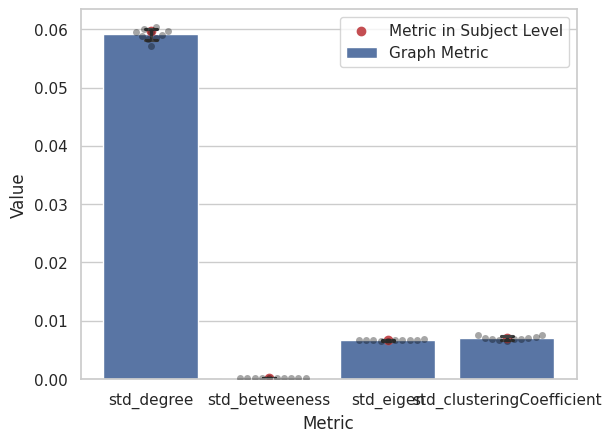

In [27]:
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(0)
# Convert IEEE_metric to DataFrame
IEEE_df = pd.DataFrame.from_dict(IEEE_metric['sub-126BPCP021001']['std_metric'], orient='index', columns=['Value']).reset_index()
IEEE_df = IEEE_df.rename(columns={'index': 'Metric'})

# Convert subdict_ses1 to DataFrame and melt
MCA_df = pd.DataFrame(subdict_ses1['sub-126BPCP021001']['std_metric'])
MCA_long_df = pd.melt(MCA_df, var_name='Metric', value_name='Value')

# Create the bar plot with standard deviation caps
sns.barplot(x="Metric", y="Value", data=MCA_long_df, capsize=.1, errorbar="sd", label="Graph Metric")

# Overlay the swarm plot with individual data points
sns.swarmplot(x="Metric", y="Value", data=MCA_long_df, color="0", alpha=.35)

# Plot the IEEE metric data
plt.scatter(IEEE_df['Metric'], IEEE_df['Value'], marker='o', color='r', label='Metric in Subject Level')

# Add labels and legend
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend()

In [33]:
df_IEEE_metric=pd.DataFrame.from_dict(IEEE_metric['sub-126BPCP021007']['std_metric'])
df_IEEE_metric

ValueError: If using all scalar values, you must pass an index

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.subplots as sp
import numpy as np
from scipy.stats import norm

# Example data structure similar to df_sd_dic
np.random.seed(42)  # For reproducibility

# Initialize Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Histograms of Keys for iteration of one subject"),
    dcc.Dropdown(
        id='subject-dropdown',
        options=[{'label': metrics, 'value': metrics} for subject in iter_dict['graph_metrics'].keys()],
        multi=True,  # Allow multiple selection
        value=list(iter_dict['graph_metrics'].keys()),  # Default value: All subjects selected
        style={'width': '50%'}
    ),
    dcc.Graph(id='histogram-plot')
])

# Callback to update the plot based on selected subjects
@app.callback(
    Output('histogram-plot', 'figure'),
    [Input('subject-dropdown', 'value')]
)
def update_plot(selected_subjects):
    # Create subplots with shared x-axis
    fig = sp.make_subplots(rows=2, cols=3, subplot_titles=['degree_centralities', 'betweenness_centralities', 'eigenvector_centralities', 'clustering_coefficients', 'shortest_path_lengths', 'small_worldness'], shared_yaxes=True, shared_xaxes='rows',
                           row_heights=[0.4, 0.4])

    # Loop through the selected subjects and add histograms
    for i, key in enumerate(['degree_centralities', 'betweenness_centralities', 'eigenvector_centralities', 'clustering_coefficients', 'shortest_path_lengths', 'small_worldness'], start=1):
        for subject in selected_subjects:
            # Add histogram for each selected subject
            fig.add_trace(go.Histogram(x=iter_dict['graph_metrics'][subject][key], name=f'{subject} - {key}'), row=(i-1)//3 + 1, col=(i-1)%3 + 1, )
            # x_curve = np.linspace(min(df_sd_dic[subject][key]), max(df_sd_dic[subject][key]), 100)
            # y_curve = norm.pdf(x_curve, loc=np.mean(df_sd_dic[subject][key]), scale=np.std(df_sd_dic[subject][key]))
            # fig.add_trace(go.Scatter(x=x_curve, y=y_curve, mode='lines', name=f'Normal Curve - {subject} - {key}'), row=(i-1)//3 + 1, col=(i-1)%3 + 1)

    # Update layout for better readability
    fig.update_layout(
        title_text=f'Histograms of graph metrics for Subjects',
        # xaxis_title='standard deviation',
        height=800,  # Adjust the height of the entire figure
    )
    fig.update_xaxes(tickformat='e', exponentformat='e', showticksuffix='none', ticksuffix='e+0')


    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)



